# Portfolio Optimization via Regression
## FINM 36700 Discussion
### Mark Hendricks
### Autumn 2021

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import QuantileRegressor
from sklearn.decomposition import PCA

from scipy.optimize import lsq_linear

import matplotlib.pyplot as plt

import yfinance as yf

import sys
sys.path.insert(0, '../cmds/')
from portfolio import *

## Get Data

- Try using the data from HW#1, related to the Harvard Endowment.
- Or try a handful of equities downloaded from Yahoo.

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

rets_Harvard, retsx_Harvard = rets, retsx

In [3]:
DATAPATH = '../data/midterm_2_data_pricing.xlsx'
SHEET = 'assets (excess returns)'
retsx = pd.read_excel(DATAPATH,sheet_name=SHEET)
retsx.set_index('Date',inplace=True)
rets = retsx + .01/12

rets_Commodities, retsx_Commodities = rets, retsx

In [4]:
symbols = ['SPY']
# add multi-asset ETF symbols at cost of losing 15+ years of data
# symbols += ['IYR','EFA','EEM','IEF', 'TIP', 'DBC','PSP','QAI','BWX','HYG','SHV']
symbols += ['AAPL','MSFT','JNJ','MMM','GE','DIS','DHR','HON', 'JPM', 'BAM', 'MCD', 'F', 'CVX', 'HD','LOW', 'CAT','NUE','DHI','XOM', 'BA','FDX','BAC','WMT','NYT','TM']
start_date = '1990-12-31'
end_date = '2021-11-30'
df = yf.download(symbols,start_date,end_date)['Adj Close']

rets = df.resample('M').last().pct_change()
rets.dropna(axis=0,inplace=True)
if 'SHV' in rets.columns:
    retsx = rets.subtract(rets['SHV'],axis=0).drop(columns=['SHV'])
else:
    rf = .01/12
    retsx = rets - rf

rets_Equities, retsx_Equities = rets, retsx

[*********************100%***********************]  26 of 26 completed


In [5]:
#USE_DATA = 'Harvard'
#USE_DATA = 'Commodities'
#USE_DATA = 'Equities'
USE_DATA = 'ALL'

if USE_DATA == 'Harvard':
    rets, retsx = rets_Harvard, retsx_Harvard
elif USE_DATA == 'Commodities':
    rets, retsx = rets_Commodities, retsx_Commodities
elif USE_DATA == 'Equities':
    rets, retsx = rets_Equities, retsx_Equities
else:
    rets = pd.concat([rets_Harvard.drop(columns=['SPY']), rets_Commodities, rets_Equities],axis=1,join='inner')
    retsx = pd.concat([retsx_Harvard.drop(columns=['SPY']), retsx_Commodities, retsx_Equities],axis=1,join='inner')

Number of assets: 50
Number of periods: 147


,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP,...,LOW,MCD,MMM,MSFT,NUE,NYT,SPY,TM,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-30,0.114637,0.155029,0.229649,0.022329,0.137906,-0.001554,0.295597,-0.028005,0.008439,-0.018505,...,0.182320,-0.024289,0.157654,0.102051,0.065187,0.189432,0.098513,0.249720,-0.033463,-0.021832
2009-05-31,0.132390,0.159872,0.054364,0.028337,0.029027,0.163135,0.023200,-0.020301,0.054144,0.020438,...,-0.116648,0.106129,-0.000870,0.036811,0.078302,0.225933,0.057620,0.011673,-0.008607,0.045573
2009-06-30,-0.014648,-0.023094,0.044849,-0.004036,0.032918,-0.026858,-0.025463,-0.006171,0.004549,0.001382,...,0.020208,-0.018206,0.051706,0.137032,0.018930,-0.165985,-0.001488,-0.058475,-0.026969,0.007241
2009-07-31,0.100442,0.110173,0.143274,0.015353,0.069217,0.018595,0.105826,0.008345,0.031311,0.000906,...,0.161648,-0.043102,0.172544,-0.011350,0.000067,0.427479,0.073772,0.113691,0.028894,0.006033
2009-08-31,0.044595,-0.013571,0.032977,-0.004587,-0.017405,-0.040800,0.131503,0.007198,0.007193,0.007978,...,-0.043575,0.029611,0.029038,0.053103,0.000741,-0.033870,0.036106,0.011165,0.024609,-0.012449


MIN Correlation pair is ('JPM', 'IEF')
MAX Correlation pair is ('PSP', 'EFA')


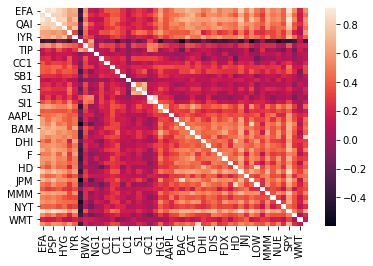

In [6]:
Ntime, Nassets = retsx.shape
print(f'Number of assets: {Nassets:.0f}')
print(f'Number of periods: {Ntime:.0f}')
display(retsx.head())
display_correlation(retsx)

## Figure of Mean-Variance Optimization

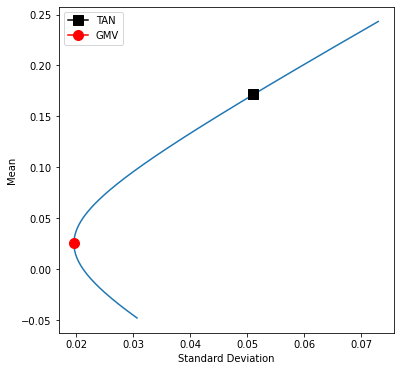

In [7]:
import os
import sys
if os.path.isfile('../dev/extras.py'):
    sys.path.insert(0, '../dev')
    from extras import MVweights, plotMV

    figrets = rets
    label = 'GMV'
    wstar = pd.DataFrame(MVweights(figrets,target=label),index=figrets.columns,columns=[label])
    label = 'TAN'
    wstar[label] = MVweights(figrets,target=label,isexcess=False)
    
    wts_a = wstar['TAN']
    wts_b = wstar['GMV']
    fig = plotMV(wts_a,wts_b,figrets.mean(),figrets.cov(),labels=['TAN','GMV'],annualize=12)

### Description of Individual Asset Sharpe Ratios

In [8]:
(retsx.mean()/retsx.std()).to_frame().describe().rename({0:'Sharpe Ratio Summary'},axis=1).drop(index=['count']).style.format('{:.2%}'.format)

,Sharpe Ratio Summary
mean,17.84%
std,9.43%
min,1.63%
25%,8.99%
50%,17.57%
75%,24.90%
max,35.60%


# Mean-Variance Optimization is OLS

## OLS when Projecting a Constant

The OLS estimator of regressing $y$ on $X$ (no intercept) is:
$$\boldsymbol{\hat{\beta}_{y|x}} = \left(\boldsymbol{X}'\boldsymbol{X}\right)^{-1}\boldsymbol{X}'\boldsymbol{y}$$
Though it may seem unusual we could regress a constant on regressors:
$$1 = \beta x_t + \epsilon_t$$
_Obviously, if we included an intercept, the regression would be degenerate with $\alpha=1, \beta=0, \epsilon_t=0$._

Regress the constant, 1, on returns. So $X=R$ and $y=1$.
$$\boldsymbol{\hat{\beta}_{1|R}} = \left(\boldsymbol{R}'\boldsymbol{R}\right)^{-1}\boldsymbol{R}'\boldsymbol{1_n}$$ 

### The OLS solution as sample moments
$$\boldsymbol{\hat{\beta}_{1|R}} = \boldsymbol{\hat{\Sigma}_0^{-1}\hat{\mu}}$$ 

**Scaling**

The OLS betas will not sum to one, but we can include a scaling factor to ensure this, and we can refer to this as a weight vector, $\boldsymbol{w}_{ols}$:
$$\boldsymbol{w}_{ols} = \boldsymbol{\hat{\Sigma}_0^{-1}\hat{\mu}}\ \hat{c}_{ols}$$

$$\hat{c}_{ols} = \frac{1}{\boldsymbol{1}'_k\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}}$$

## Mean-Variance Solution

Using sample estimates for the moments above, we have:
$$\boldsymbol{\hat{w}}_{tan} = \boldsymbol{\hat{\Sigma}^{-1}\hat{\mu}}\hat{c}_{tan}$$

$$\hat{c}_{\text{tan}} = \frac{1}{\boldsymbol{1_k'\hat{\Sigma}^{-1}\hat{\mu}}}$$

where $\hat{c}_{\text{mv}}$ is a constant that ensures $\boldsymbol{\hat{w}}_{tan}$ sums to 1. 

## Equality

If we go through the tedious linear algebra, we find
$$\boldsymbol{\hat{w}}_{tan} = 
\boldsymbol{\hat{\Sigma}}^{-1}\boldsymbol{\hat{\mu}}\hat{c}_{tan} =
\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}\hat{c}_{ols} = \boldsymbol{\hat{w}}_{ols}$$


## Scaling of the constant used as the dependent variable
- We are using the constant $1$ on the left-hand-side as the dependent variable.
- For OLS, the scaling of this constant simply changes the sum of the weights. Thus, it impacts the exact scaling constant, $\hat{c}_{ols}$, which enforces the weights to sum to 1.

### Going beyond MV, the scaling may matter!
- For more complex optimization, the solution weights do not scale proportionally with the target mean, as they do for the excess-return Mean-Variance frontier.
- In those cases, we may need to rescale the regressand constant to trace out the frontier.

## Conclusion
**Mean Variance Optimization is equivalent to OLS of a constant on the returns.**

This means...
- We can get statistical significance of the MV weights.
- We can restrict the MV solution in ways we commonly restrict OLS. This includes Non-Negative Least Squares.
- We can restrict the number of positions in the MV solution. (LASSO).
- We can restrict the position sizes in the MV solution via a penalty parameter instead of $2n$ boundary constraints. (Ridge).

In [9]:
wts = tangency_weights(retsx).rename({0:'MV'},axis=1)

# for OLS, doesn't matter what scaling we give y, just use y=1
# but note that below this scaling may matter
y = np.ones((Ntime,1))
X = retsx

beta = LinearRegression(fit_intercept=False).fit(X,y).coef_.transpose()
# rescale OLS beta to sum to 1
beta /= beta.sum()

wts['OLS'] = beta
wts.style.format('{:.2%}'.format)

,MV,OLS
EFA,-6.31%,-6.31%
EEM,-15.63%,-15.63%
PSP,5.88%,5.88%
QAI,-97.76%,-97.76%
HYG,34.61%,34.61%
DBC,-2.79%,-2.79%
IYR,-19.30%,-19.30%
IEF,91.93%,91.93%
BWX,-1.72%,-1.72%
TIP,45.25%,45.25%


### Confirmation
- They are the same weights!
- So we drop the redundant `OLS` column.

### Statistical Significance (in-sample) of these weights
Get them from the usual OLS t-stats!

In [10]:
tstats = pd.DataFrame(sm.OLS(y, X).fit().tvalues,columns=['t-stat'])
display(tstats.loc[tstats['t-stat'].abs()>2].sort_values('t-stat',ascending=False).style.format('{:.2f}'.format))

,t-stat
DHR,2.38
IEF,2.06


# No Short Positions

Implement via Non-Negative Least Squares (NNLS)
- Do this instead of using Constrained Optimization with $k$ boundary constraints.
- NNLS is doing the Linear Programming with inequalities the same as we would do with Constrained Optimization, but it saves us some work in implementation.

In [11]:
# for NLLS, scaling of y does not matter

y = np.ones((Ntime,1))
X = retsx

beta = LinearRegression(fit_intercept=False, positive=True).fit(X,y).coef_.transpose()
beta /= beta.sum()
beta

wts['NNLS'] = beta
wts.loc[wts['NNLS']>0, ['NNLS']].sort_values('NNLS',ascending=False)

,NNLS
IEF,0.639812
MSFT,0.073286
HD,0.054009
DHR,0.052908
JPM,0.044332
NYT,0.030371
LC1,0.028921
AAPL,0.023187
MCD,0.019120
PA1,0.014845


# Regularized Regressions are Useful

The OLS interpretation of MV makes clear that due to multicolinearity, the optimal in-sample weights can be extreme.

Instead, we may want to use regularized regression to deal with the following constraints.
**Constraints**
1. restrict gross leverage, $\sum_{i}^n |w^i| \le L$
2. limit the total number of positions, $\sum_{i}^n\boldsymbol{1}_{>0}\left(w^i\right) \le K$

This can be done somewhat clumsily with the traditional constrained optimization.

But other challenges are hard to address with traditional techniques

**Challenges**
1. Limit positions from being too large, without specifying security-specific boundaries.
1. Put more emphasis on out-of-sample performance
1. Implement a Bayesian approach to Mean-Variance optimization

## Ridge Estimation

- Ridge estimation may help with the challenges above.
- Except it will NOT limit the total number of positions.

The Ridge estimator is the optimized solution for a regularized regression with an L2 penalty.

Recall that the Ridge estimator is 
$$\hat{\boldsymbol{\beta}}^{\text{ridge}} = \left(\boldsymbol{X}'\boldsymbol{X} + \lambda\mathcal{I}_n\right)^{-1}\left(\boldsymbol{X}\boldsymbol{y}\right)$$
where
- $\mathcal{I}_n$ is the $n\times n$ identity matrix.
- $\lambda$ is a hyperparameter ("tuning" parameter) related to the L2 penalty.

Note that this is the exact same as OLS, except we have a modified second-moment matrix. In our application of regressing 1 on returns without an intercept, the point is that instead of the OLS calculation,
$$\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}$$
we use 
$$\left(\boldsymbol{\hat{\Sigma}}_0 + \lambda\mathcal{I}_n\right)^{-1}\boldsymbol{\hat{\mu}}$$
- For $\lambda=0$, we simply have OLS.
- For large $\lambda$, we are diagonalizing the second-moment matrix. (Since we do not regress on an intercept, this is the uncentered second-moment matrix, not quite the covariance matrix.)

### Conclusion
- The Ridge estimator is diagonalizing the second-moment matrix, which makes it more stable for inversion.
- This reduces its sensitivity to small changes in the data, and allows it to perform more consistently out-of-sample, though less optimally in-sample.
- Conceptually, this means that it constructs less extreme long-short weights given that it diminishes the magnitudes of the correlations relative to the main diagonal.
- Statistically, the extra term on the second-moment matrix is reducing the impact the multicolinearity of the asset returns have on the estimate.

## LASSO Estimation

- LASSO estimation helps with the challenges above.
- Additionally, LASSO can reduce the number of positions, (dimension reduction.)

Unlike Ridge, there is no closed-form solution for the LASSO estimator.

## Bayesian Interpretation

**Ridge**
- The Ridge estimator is a Bayesian posterior assuming a Normally distributed prior on the betas, updated via normally distributed sample data.

**LASSO**
- The LASSO estimator is a Bayesian posterior assuming a Laplace-distributed prior on the betas, updated via normally distributed sample data.

This does not mean Ridge requires us to believe the data is normally distributed. That is an assumption to interpret it as thte Bayesian solution.

Figure 6.2 from *Introduction to Statistical Learning* (James, Witten, Hastie, and Tibshirani) gives a useful visualization of these priors, and why they lead to Ridge having muted, but non-zero betas, whereas LASSO has (potentially many) betas equal to zero and others that are not muted as much as in Ridge.
<img src="../refs/regularized_bayesian_priors.png" width="400"/>

*If figure does not display, make sure you have the `refs` directory in the repo, at the expected relative path.*


In [12]:
def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.25
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty

In [13]:
GROSS_LIMIT = 2

# scaling of y will impact the solution if penalty held constant
# here, we adjust the penalty to ensure the scaling, so initial scaling of y is less important

betas, penalty_ridge = penalized_reg_limit_gross(Ridge, rets, y, limit=GROSS_LIMIT, fit_intercept=False)
wts['Ridge'] = betas.transpose()
betas, penalty_lasso = penalized_reg_limit_gross(Lasso, rets, y, limit=GROSS_LIMIT, fit_intercept=False)
wts['Lasso'] = betas.transpose()

print(f'Penalty for Ridge: {penalty_ridge : .2e}.\nPenalty for LASSO: {penalty_lasso : .2e}.')

Penalty for Ridge:  1.02e+00.
Penalty for LASSO:  8.08e-04.


## Diagonalization and Shrinkage

### Diagonalization
- Diagonalize the covariance matrix (set all off-diagonal terms to 0).
- This was popular long before Ridge and continues to be.

### Shrinkage Estimators
- "Shrink" the covariance matrix going into MV estimation by mixing a diagonalized version of the matrix with the full matrix, according to some mixing parameter.
- The mixing parameter may change over time, depending on the data.
- This is equivalent to Ridge for certain specification of the mixing parameter.

So Ridge is another lense for a popular approach to MV optimization.

In [14]:
covDiag = np.diag(np.diag(retsx.cov()))
temp = np.linalg.solve(covDiag,retsx.mean())
wts['Diagonal'] = temp / temp.sum()

# Performance

In [15]:
if 'Equal' not in wts.columns:
    wts.insert(0,'Equal',np.ones_like(Nassets)/Nassets)
if 'OLS' in wts.columns:
    wts.drop(columns=['OLS'],inplace=True)

retsx_ports = retsx @ wts

In [16]:
display(performanceMetrics(retsx_ports, annualization=12))
display(tailMetrics(retsx_ports))
display(get_ols_metrics(retsx['SPY'], retsx_ports,annualization=12))

,Mean,Vol,Sharpe,Min,Max
Equal,0.139940,0.129974,1.076680,-0.137113,0.119254
MV,0.199192,0.062050,3.210188,-0.022944,0.060179
NNLS,0.097960,0.044657,2.193587,-0.022817,0.036643
Ridge,0.249860,0.124655,2.004414,-0.068792,0.108288
Lasso,0.145646,0.051448,2.830935,-0.021456,0.045637
Diagonal,0.136254,0.104596,1.302662,-0.106809,0.096471


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
Equal,-0.242410,1.975321,-0.044466,-0.072959,-0.197584,2019-12-31,2020-03-31,2020-08-31,244 days
MV,0.079710,-0.549218,-0.011896,-0.017152,-0.026462,2020-12-31,2021-02-28,2021-04-30,120 days
NNLS,0.020319,-0.565257,-0.014182,-0.016672,-0.032956,2013-04-30,2013-08-31,2013-10-31,184 days
Ridge,-0.074259,-0.269243,-0.036993,-0.052359,-0.092665,2020-01-31,2020-03-31,2020-05-31,121 days
Lasso,0.022291,-0.578269,-0.010280,-0.016841,-0.030737,2020-12-31,2021-02-28,2021-04-30,120 days
Diagonal,-0.275796,1.668295,-0.039537,-0.057695,-0.149416,2020-01-31,2020-03-31,2020-07-31,182 days


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
Equal,0.003040,0.868032,0.865869,0.161216,0.063858
MV,0.174426,0.157031,0.124333,1.268483,3.004001
NNLS,0.063534,0.218276,0.463791,0.448787,1.942898
Ridge,0.129108,0.765640,0.732357,0.326342,2.002011
Lasso,0.114438,0.197876,0.287171,0.736048,2.634572
Diagonal,0.021611,0.726904,0.937595,0.187444,0.827075


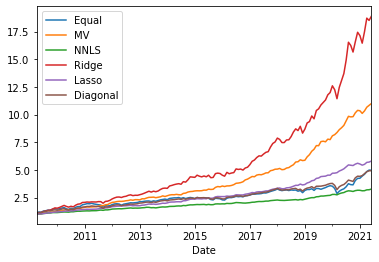

In [17]:
(1+retsx_ports).cumprod().plot();

MIN Correlation pair is ('Equal', 'MV')
MAX Correlation pair is ('Diagonal', 'Equal')


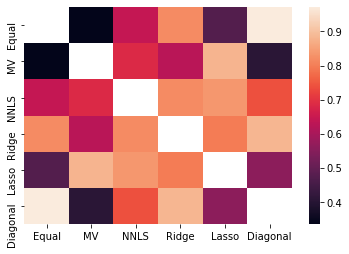

In [18]:
display_correlation(retsx_ports)

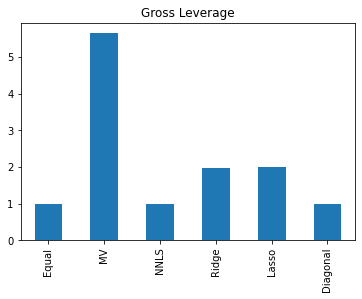

In [19]:
wts.abs().sum().plot.bar(title='Gross Leverage');

In [20]:
wts.style.format('{:.2%}'.format).background_gradient(cmap='Blues')

,Equal,MV,NNLS,Ridge,Lasso,Diagonal
EFA,2.00%,-6.31%,0.00%,-4.19%,-9.56%,2.10%
EEM,2.00%,-15.63%,0.00%,-6.09%,-14.28%,1.44%
PSP,2.00%,5.88%,0.00%,-2.32%,-0.00%,2.04%
QAI,2.00%,-97.76%,0.00%,-0.90%,-0.00%,6.85%
HYG,2.00%,34.61%,0.00%,2.18%,0.00%,6.11%
DBC,2.00%,-2.79%,0.00%,-8.44%,-3.62%,0.18%
IYR,2.00%,-19.30%,0.00%,2.10%,-4.02%,2.76%
IEF,2.00%,91.93%,63.98%,6.47%,65.82%,5.58%
BWX,2.00%,-1.72%,0.00%,-0.51%,-0.00%,2.06%
TIP,2.00%,45.25%,0.00%,3.69%,0.00%,9.83%


***